In [173]:
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics


In [186]:
df_extrapolations.to_pickle('testpickel')

In [174]:
def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [175]:
def get_num_par(model_id):
    if model_id == 'last1':
        return 1
    if model_id in ['pow2', 'log2', 'exp2', 'lin2', 'ilog2']:
        return 2
    if model_id in ['pow3', 'exp3', 'vap3', 'expp3', 'expd3', 'logpower3']:
        return 3
    if model_id in ['mmf4', 'wbl4', 'exp4', 'pow4']:
        return 4

def get_fun_model_id(beta,model_id):
    num_par = get_num_par(model_id)
    fun = None

    # unpack parameters
    if num_par == 1:
        a = beta[0]
    if num_par == 2:
        a, b = beta[0], beta[1]
    if num_par == 3:
        a, b, c = beta[0], beta[1], beta[2]
    if num_par == 4:
        a, b, c, d = beta[0], beta[1], beta[2], beta[3]

    # define curve models
    if model_id == 'pow2':
        fun = lambda x: -a * x ** (-b)
    if model_id == 'pow3':
        fun = lambda x: a - b * x ** (-c)
    if model_id == 'log2':
        fun = lambda x: -a * np.log(x) + b
    if model_id == 'exp3':
        fun = lambda x: a * np.exp(-b * x) + c
    if model_id == 'exp2':
        fun = lambda x: a * np.exp(-b * x)
    if model_id == 'lin2':
        fun = lambda x: a * x + b
    if model_id == 'vap3':
        fun = lambda x: np.exp(a + b / x + c * np.log(x))
    if model_id == 'mmf4':
        fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
    if model_id == 'wbl4':
        fun = lambda x: (c - b * np.exp(-a * (x ** d)))
    if model_id == 'exp4':
        fun = lambda x: c - np.exp(-a * (x ** d) + b)
    if model_id == 'expp3':
        # fun = lambda x: a * np.exp(-b*x) + c
        fun = lambda x: c - np.exp((x - b) ** a)
    if model_id == 'pow4':
        fun = lambda x: a - b * (x + d) ** (-c)  # has to closely match pow3
    if model_id == 'ilog2':
        fun = lambda x: b - (a / np.log(x))
    if model_id == 'expd3':
        fun = lambda x: c - (c - a) * np.exp(-b * x)
    if model_id == 'logpower3':
        fun = lambda x: a / (1 + (x / np.exp(b)) ** c)
    if model_id == 'last1':
        fun = lambda x: (a + x) - x  # casts the prediction to have the correct size
    return fun
    

In [182]:
def df_compute_metrics_mean_curve(df,df_info):
    pbar = tqdm(total=len(df))
    rows_metrics = []
    for i in range(0,len(df)):
        row = df.iloc[i,:]
        anchor_prediction, score = get_info_mean_curve(df_info, row.openmlid, row.learner)
        rows_metrics.append(metrics_per_row(row,score,anchor_prediction))
        pbar.update(1)
    pbar.close()
    df_metrics = pd.DataFrame(rows_metrics,columns=['MSE trn','MSE tst','MSE tst last','L1 trn','L1 tst','L1 tst last','max anchor seen','percentage','n','curve_model'])
    return df_metrics

def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

def metrics_per_row(row, score, anchor_prediction):
    
    max_anchor_seen = row.max_anchor_seen
    prediction = row.prediction
    max_anchor = np.max(anchor_prediction)
    percentage_train = np.round(max_anchor_seen/max_anchor*100)/100

    trn_ind = np.argwhere(max_anchor_seen == anchor_prediction)[0][0] # recover offset
    trn_indices = range(0,(trn_ind+1))
    tst_indices = range(trn_ind+1,len(anchor_prediction))
    n_trn = len(trn_indices)
    
    y_trn_hat = prediction[trn_indices]
    y_trn = score[trn_indices]
    y_tst_hat = prediction[tst_indices]
    y_tst = score[tst_indices]

    MSE_trn = np.mean((y_trn - y_trn_hat)**2)
    MSE_tst = np.mean((y_tst - y_tst_hat)**2)
    MSE_tst_last = (y_tst[-1] -  y_tst_hat[-1])**2
    L1_trn = np.mean((y_trn -y_trn_hat)**2)
    L1_tst = np.mean((y_tst - y_tst_hat)**2)
    L1_tst_last = (y_tst[-1] - y_tst_hat[-1])**2
    
    return [MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max_anchor_seen,percentage_train,n_trn,row.curve_model]

In [183]:

df_metrics_recomputed = df_compute_metrics_mean_curve(df_extrapolations, df_anchors_and_scores)


  0%|          | 0/301210 [00:00<?, ?it/s]

TypeError: string indices must be integers

# Cleaning the data and processing

In [176]:
df = pd.read_csv('lcdb.csv')
df_metrics = pd.read_csv('metrics.csv')
df_extrapolations = pd.read_csv('extrapolations.csv')
#df_anchors_and_scores = pd.read_csv('anchors_scores.csv')

In [177]:
def get_anchors_and_scores_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            rows.append([openmlid, learner, sizes, mean_scores])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "anchor_prediction", "score"])

In [180]:
df_metrics

Unnamed: 0   MSE trn   MSE tst  MSE tst last    L1 trn    L1 tst  \
0                0  0.000001  0.020309      0.060189  0.000001  0.020309   
1                1  0.000001  0.016770      0.045341  0.000001  0.016770   
2                2  0.000005  0.005540      0.013464  0.000005  0.005540   
3                3  0.000008  0.002852      0.006278  0.000008  0.002852   
4                4  0.000009  0.002108      0.004178  0.000009  0.002108   
...            ...       ...       ...           ...       ...       ...   
301198      301198  0.000052  0.000904      0.001640  0.000052  0.000904   
301199      301199  0.000067  0.000471      0.000729  0.000067  0.000471   
301200      301200  0.000082  0.000153      0.000216  0.000082  0.000153   
301201      301201  0.000075  0.000222      0.000213  0.000075  0.000222   
301202      301202  0.000078  0.000079      0.000079  0.000078  0.000079   

        L1 tst last  max anchor seen  percentage   n curve_model  
0          0.060189               45        0.02   4        pow3  
1          0.045341               64        0.02   5        pow3  
2          0.013464               91        0.04   6        pow3  
3          0.006278              128        0.05   7        pow3  
4          0.004178              181        0.07   8        pow3  
...             ...              ...         ...  ..         ...  
301198     0.001640              128        0.16   7   logpower3  
301199     0.000729              181        0.22   8   logpower3  
301200     0.000216              256        0.32   9   logpower3  
301201     0.000213              362        0.45  10   logpower3  
301202     0.000079              512        0.63  11   logpower3  

[301203 rows x 11 columns]

In [181]:
df_extrapolations

Unnamed: 0  openmlid                           learner  \
0                0         3                        SVC_linear   
1                1         3                        SVC_linear   
2                2         3                        SVC_linear   
3                3         3                        SVC_linear   
4                4         3                        SVC_linear   
...            ...       ...                               ...   
301205      301205       910  sklearn.tree.ExtraTreeClassifier   
301206      301206       910  sklearn.tree.ExtraTreeClassifier   
301207      301207       910  sklearn.tree.ExtraTreeClassifier   
301208      301208       910  sklearn.tree.ExtraTreeClassifier   
301209      301209       910  sklearn.tree.ExtraTreeClassifier   

        max_anchor_seen                                         prediction  \
0                    45  [0.6866 0.7361 0.7793 0.8221 0.8645 0.9051 0.9...   
1                    64  [0.6864 0.7363 0.7793 0.8214 0.8626 0.9016 0.9...   
2                    91  [0.6851 0.7377 0.7808 0.8211 0.8587 0.8925 0.9...   
3                   128  [0.6842 0.7388 0.7823 0.822  0.858  0.8894 0.9...   
4                   181  [0.6837 0.7392 0.783  0.8224 0.8577 0.8881 0.9...   
...                 ...                                                ...   
301205              128  [0.5817 0.5936 0.6046 0.6162 0.6284 0.6408 0.6...   
301206              181  [0.5798 0.5928 0.6049 0.6177 0.6311 0.6449 0.6...   
301207              256  [0.5778 0.5919 0.605  0.6188 0.6334 0.6483 0.6...   
301208              362  [0.5778 0.5919 0.605  0.6188 0.6334 0.6484 0.6...   
301209              512  [0.5766 0.5912 0.6047 0.6191 0.6342 0.6498 0.6...   

       curve_model                                               beta  
0             pow3  (1.8259050363918465, 1.60011081278419, 0.12250...  
1             pow3  (1.5915489561835012, 1.3955173506046286, 0.156...  
2             pow3  (1.1986751382205407, 1.171780585157037, 0.2975...  
3             pow3  (1.1121255708956674, 1.2130204193755982, 0.375...  
4             pow3  (1.0833170977575124, 1.253142327625819, 0.4122...  
...            ...                                                ...  
301205   logpower3  (47.80976090118021, 80.7970006134594, -0.05635...  
301206   logpower3  (66.19090693689249, 79.35081398593735, -0.0617...  
301207   logpower3  (89.90912658715132, 78.33504461893112, -0.0667...  
301208   logpower3  (102.62142096273733, 80.35794040149847, -0.066...  
301209   logpower3  (139.15641468182756, 82.17911182251908, -0.069...  

[301210 rows x 7 columns]

In [5]:
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df)


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscrimina

In [6]:
print('some strange values:')
print(df_metrics.isin([np.nan, np.inf, -np.inf]).sum())
df_metrics_na = df_metrics.replace([np.inf, -np.inf], np.nan)


some strange values:
Unnamed: 0           0
MSE trn              0
MSE tst            262
MSE tst last       262
L1 trn               0
L1 tst             262
L1 tst last        262
max anchor seen      0
percentage           0
n                    0
curve_model          0
dtype: int64


In [171]:
df_extrapolations_no_curve_model = df_extrapolations.loc[:, df_extrapolations.columns != 'curve_model']
df_total = pd.concat([df_extrapolations_no_curve_model,df_metrics],axis=1)
df_total

Unnamed: 0  openmlid                           learner  \
0                0         3                        SVC_linear   
1                1         3                        SVC_linear   
2                2         3                        SVC_linear   
3                3         3                        SVC_linear   
4                4         3                        SVC_linear   
...            ...       ...                               ...   
301205      301205       910  sklearn.tree.ExtraTreeClassifier   
301206      301206       910  sklearn.tree.ExtraTreeClassifier   
301207      301207       910  sklearn.tree.ExtraTreeClassifier   
301208      301208       910  sklearn.tree.ExtraTreeClassifier   
301209      301209       910  sklearn.tree.ExtraTreeClassifier   

        max_anchor_seen                                         prediction  \
0                    45  [0.6866 0.7361 0.7793 0.8221 0.8645 0.9051 0.9...   
1                    64  [0.6864 0.7363 0.7793 0.8214 0.8626 0.9016 0.9...   
2                    91  [0.6851 0.7377 0.7808 0.8211 0.8587 0.8925 0.9...   
3                   128  [0.6842 0.7388 0.7823 0.822  0.858  0.8894 0.9...   
4                   181  [0.6837 0.7392 0.783  0.8224 0.8577 0.8881 0.9...   
...                 ...                                                ...   
301205              128  [0.5817 0.5936 0.6046 0.6162 0.6284 0.6408 0.6...   
301206              181  [0.5798 0.5928 0.6049 0.6177 0.6311 0.6449 0.6...   
301207              256  [0.5778 0.5919 0.605  0.6188 0.6334 0.6483 0.6...   
301208              362  [0.5778 0.5919 0.605  0.6188 0.6334 0.6484 0.6...   
301209              512  [0.5766 0.5912 0.6047 0.6191 0.6342 0.6498 0.6...   

                                                     beta  Unnamed: 0  \
0       (1.8259050363918465, 1.60011081278419, 0.12250...         0.0   
1       (1.5915489561835012, 1.3955173506046286, 0.156...         1.0   
2       (1.1986751382205407, 1.171780585157037, 0.2975...         2.0   
3       (1.1121255708956674, 1.2130204193755982, 0.375...         3.0   
4       (1.0833170977575124, 1.253142327625819, 0.4122...         4.0   
...                                                   ...         ...   
301205  (47.80976090118021, 80.7970006134594, -0.05635...         NaN   
301206  (66.19090693689249, 79.35081398593735, -0.0617...         NaN   
301207  (89.90912658715132, 78.33504461893112, -0.0667...         NaN   
301208  (102.62142096273733, 80.35794040149847, -0.066...         NaN   
301209  (139.15641468182756, 82.17911182251908, -0.069...         NaN   

         MSE trn   MSE tst  MSE tst last    L1 trn    L1 tst  L1 tst last  \
0       0.000001  0.020309      0.060189  0.000001  0.020309     0.060189   
1       0.000001  0.016770      0.045341  0.000001  0.016770     0.045341   
2       0.000005  0.005540      0.013464  0.000005  0.005540     0.013464   
3       0.000008  0.002852      0.006278  0.000008  0.002852     0.006278   
4       0.000009  0.002108      0.004178  0.000009  0.002108     0.004178   
...          ...       ...           ...       ...       ...          ...   
301205       NaN       NaN           NaN       NaN       NaN          NaN   
301206       NaN       NaN           NaN       NaN       NaN          NaN   
301207       NaN       NaN           NaN       NaN       NaN          NaN   
301208       NaN       NaN           NaN       NaN       NaN          NaN   
301209       NaN       NaN           NaN       NaN       NaN          NaN   

        max anchor seen  percentage    n curve_model  
0                  45.0        0.02  4.0        pow3  
1                  64.0        0.02  5.0        pow3  
2                  91.0        0.04  6.0        pow3  
3                 128.0        0.05  7.0        pow3  
4                 181.0        0.07  8.0        pow3  
...                 ...         ...  ...         ...  
301205              NaN         NaN  NaN         NaN  
301206              NaN         NaN 

In [46]:
df_total_clean.iloc[0,:].MSE_trn

1.3321905599994505e-06

In [8]:
df_total.describe()

Unnamed: 0       openmlid  max_anchor_seen     Unnamed: 0  \
count  301210.000000  301210.000000    301210.000000  301203.000000   
mean   150604.500000     479.066977      4407.676179  150601.000000   
std     86951.981629     326.777097     26788.555624   86949.960903   
min         0.000000       3.000000        45.000000       0.000000   
25%     75302.250000     180.000000       128.000000   75300.500000   
50%    150604.500000     399.000000       362.000000  150601.000000   
75%    225906.750000     807.000000      1024.000000  225901.500000   
max    301209.000000     910.000000    524288.000000  301202.000000   

            MSE trn        MSE tst   MSE tst last        L1 trn  \
count  3.012030e+05   3.009410e+05   3.009410e+05  3.012030e+05   
mean   2.182149e-03  3.582782e+298  7.059158e+299  2.182149e-03   
std    1.859653e-02            inf            inf  1.859653e-02   
min    2.311116e-33   0.000000e+00   0.000000e+00  2.311116e-33   
25%    1.885377e-05   1.761525e-04   2.003923e-04  1.885377e-05   
50%    7.446705e-05   1.360323e-03   2.273001e-03  7.446705e-05   
75%    3.737903e-04   1.223753e-02   2.583863e-02  3.737903e-04   
max    7.623948e-01  4.578164e+303  8.240695e+304  7.623948e-01   

              L1 tst    L1 tst last  max anchor seen     percentage  \
count   3.009410e+05   3.009410e+05    301203.000000  301203.000000   
mean   3.582782e+298  7.059158e+299      4407.733084       0.188983   
std              inf            inf     26788.861099       0.216425   
min     0.000000e+00   0.000000e+00        45.000000       0.000000   
25%     1.761525e-04   2.003923e-04       128.000000       0.030000   
50%     1.360323e-03   2.273001e-03       362.000000       0.100000   
75%     1.223753e-02   2.583863e-02      1024.000000       0.300000   
max    4.578164e+303  8.240695e+304    524288.000000       0.990000   

                   n  
count  301203.000000  
mean       10.544360  
std         5.080584  
min         4.000000  
25%         7.000000  
50%        10.000000  
75%        13.000000  
max        31.000000

In [172]:
df_total.isin([np.nan, np.inf, -np.inf]).sum()

Unnamed: 0           0
openmlid             0
learner              0
max_anchor_seen      0
prediction           0
beta                 0
Unnamed: 0           7
MSE trn              7
MSE tst            269
MSE tst last       269
L1 trn               7
L1 tst             269
L1 tst last        269
max anchor seen      7
percentage           7
n                    7
curve_model          7
dtype: int64

In [10]:
df_total_clean = df_total.dropna(axis=0)
df_total_clean.isin([np.nan, np.inf, -np.inf]).sum()

Unnamed: 0         0
openmlid           0
learner            0
max_anchor_seen    0
prediction         0
beta               0
Unnamed: 0         0
MSE trn            0
MSE tst            0
MSE tst last       0
L1 trn             0
L1 tst             0
L1 tst last        0
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64

In [11]:
df_total_clean = df_total_clean.rename(columns={'MSE trn':'MSE_trn','MSE tst':'MSE_tst','MSE tst last': 'MSE_tst_last', 'L1 trn':'L1_trn', 'L1 tst':'L1_tst', 'L1 tst last':'L1_tst_last'})

In [12]:
df_total_clean.describe()

Unnamed: 0       openmlid  max_anchor_seen     Unnamed: 0  \
count  300941.000000  300941.000000    300941.000000  300941.000000   
mean   150621.513396     479.126450      4340.345058  150621.513396   
std     86975.009221     326.871231     26338.706457   86975.009221   
min         0.000000       3.000000        45.000000       0.000000   
25%     75251.000000     180.000000       128.000000   75251.000000   
50%    150660.000000     399.000000       362.000000  150660.000000   
75%    225951.000000     807.000000      1024.000000  225951.000000   
max    301202.000000     910.000000    524288.000000  301202.000000   

            MSE_trn        MSE_tst   MSE_tst_last        L1_trn  \
count  3.009410e+05   3.009410e+05   3.009410e+05  3.009410e+05   
mean   2.183232e-03  3.582782e+298  7.059158e+299  2.183232e-03   
std    1.860452e-02            inf            inf  1.860452e-02   
min    2.311116e-33   0.000000e+00   0.000000e+00  2.311116e-33   
25%    1.884452e-05   1.761525e-04   2.003923e-04  1.884452e-05   
50%    7.439272e-05   1.360323e-03   2.273001e-03  7.439272e-05   
75%    3.732162e-04   1.223753e-02   2.583863e-02  3.732162e-04   
max    7.623948e-01  4.578164e+303  8.240695e+304  7.623948e-01   

              L1_tst    L1_tst_last  max anchor seen     percentage  \
count   3.009410e+05   3.009410e+05    300941.000000  300941.000000   
mean   3.582782e+298  7.059158e+299      4411.454162       0.189146   
std              inf            inf     26800.220741       0.216448   
min     0.000000e+00   0.000000e+00        45.000000       0.000000   
25%     1.761525e-04   2.003923e-04       128.000000       0.030000   
50%     1.360323e-03   2.273001e-03       362.000000       0.100000   
75%     1.223753e-02   2.583863e-02      1024.000000       0.300000   
max    4.578164e+303  8.240695e+304    524288.000000       0.990000   

                   n  
count  300941.000000  
mean       10.548274  
std         5.080746  
min         4.000000  
25%         7.000000  
50%        10.000000  
75%        13.000000  
max        31.000000

# Visualize a learning curve

In [57]:
beta_parts

['1.0415410898427293,', '1.363971359778688,', '0.4815449381117751']

In [62]:
def parse_beta(beta):
    beta_str = beta[0]
    beta_str = beta_str[1:-1]
    beta_parts = beta_str.split(' ')
    myfloat = []
    for part in beta_parts:
        part = part.replace(',','')
        part = part.replace('\n','')
        myfloat.append(float(part))
    myfloat = tuple(myfloat)
    return myfloat

In [66]:
df_selected

quartile  Unnamed: 0  openmlid     learner  max_anchor_seen  \
5           2           5         3  SVC_linear              256   
17          2          17         3  SVC_linear              256   
29          2          29         3  SVC_linear              256   
41          2          41         3  SVC_linear              256   
53          2          53         3  SVC_linear              256   
65          2          65         3  SVC_linear              256   
77          2          77         3  SVC_linear              256   
89          2          89         3  SVC_linear              256   
101         2         101         3  SVC_linear              256   
113         2         113         3  SVC_linear              256   
125         2         125         3  SVC_linear              256   
137         2         137         3  SVC_linear              256   
149         2         149         3  SVC_linear              256   
161         2         161         3  SVC_linear              256   

                                            prediction  \
5    [0.6826 0.7402 0.7845 0.8234 0.8574 0.8861 0.9...   
17   [0.7164 0.7454 0.7728 0.8021 0.8336 0.8663 0.8...   
29   [0.7101 0.7436 0.7741 0.8056 0.8381 0.8707 0.9...   
41   [ 0.7621  0.768   0.7758  0.7871  0.8039  0.82...   
53   [0.6943 0.7324 0.7726 0.8171 0.8612 0.8972 0.9...   
65   [0.7575 0.7644 0.7733 0.7862 0.805  0.8317 0.8...   
77   [0.9424 0.9424 0.9424 0.9424 0.9424 0.9424 0.9...   
89   [0.6812 0.7414 0.7862 0.8243 0.8571 0.8847 0.9...   
101  [0.6875 0.7355 0.7797 0.8223 0.8605 0.8913 0.9...   
113  [0.6863 0.7363 0.7801 0.8219 0.86   0.8913 0.9...   
125  [0.6863 0.7363 0.7801 0.8219 0.86   0.8913 0.9...   
137  [0.6803 0.7419 0.7868 0.825  0.8578 0.8855 0.9...   
149  [0.6943 0.7324 0.7726 0.8171 0.8612 0.8972 0.9...   
161  [0.6838 0.7388 0.7833 0.8233 0.8584 0.8877 0.9...   

                                                  beta  Unnamed: 0   MSE_trn  \
5    (1.0415410898427293, 1.363971359778688, 0.4815...         5.0  0.000017   
17          (0.5290654020112271, -0.10931462475100683)        17.0  0.000409   
29         (-0.09235069174037643, 0.45407182821996234)        29.0  0.000277   
41        (0.7486351789675005, -0.0011127113770041607)        41.0  0.002290   
53   (-0.3570781465106186, 0.024515936964218655, 0....        53.0  0.000033   
65         (0.0009897228492883007, 0.7416646838245692)        65.0  0.002067   
77                                  0.9423871999999998        77.0  0.017679   
89   (-0.2723971292260057, -3.654456188290843, 0.04...        89.0  0.000028   
101  (0.5099291373202449, 41.002861993477644, 0.970...       101.0  0.000001   
113  (0.24686270081045633, 0.7398747417785134, 0.95...       113.0  0.000002   
125  (0.24686322978096484, -0.3012733326404222, 0.9...       125.0  0.000002   
137            (1.476739310036564, 1.2128871454347367)       137.0  0.000028   
149  (0.5784801859568479, 0.024515937755921792, 0.9...       149.0  0.000033   
161  (1.0039631335533263, 1.7369832335956363, -0.73...       161.0  0.000009   

       MSE_tst  MSE_tst_last    L1_trn     L1_tst   L1_tst_last  \
5     0.000926  1.675560e-03  0.000017   0.000926  1.675560e-03   
17    0.034109  7.813903e-02  0.000409   0.034109  7.813903e-02   
29    0.020315  4.419817e-02  0.000277   0.020315  4.419817e-02   
41   29.056206  1.528397e+02  0.002290  29.056206  1.528397e+02   
53    0.000708  1.153716e-03  0.000033   0.000708  1.153716e-03   
65    1.590881  5.445379e+00  0.002067   1.590881  5.445379e+00   
77    0.000403  7.380133e-04  0.017679   0.000403  7.380133e-04   
89    0.003510  7.998369e-03  0.000028   0.003510  7.998369e-03   
101   0.000006  4.440890e-07  0.000001   0.000006  4.440890e-07   
113   0.000097  2.423128e-04  0.000002   0.000097  2.423128e-04   
125   0.000097  2.423128e-04  0.000002   0.000097  2.423128e-04   
137   0.001508  3.072884e-03  0.000028   0.001508  3.072884e-03   
149   0.000708  1.153716e-03  0.000033   

In [76]:
df_selected2.beta.values

array([], dtype=object)

In [82]:
def parse_prediction(beta):
    beta_str = beta[0]
    beta_str = beta_str[1:-1]
    beta_parts = beta_str.split(' ')
    myfloat = []
    for part in beta_parts:
        part = part.replace(',','')
        part = part.replace('\n','')
        myfloat.append(float(part))
    return myfloat

[0.6826,
 0.7402,
 0.7845,
 0.8234,
 0.8574,
 0.8861,
 0.9097,
 0.9299,
 0.9471,
 0.9616,
 0.9739,
 0.9843,
 0.9931,
 1.0005,
 1.0068,
 1.0105]

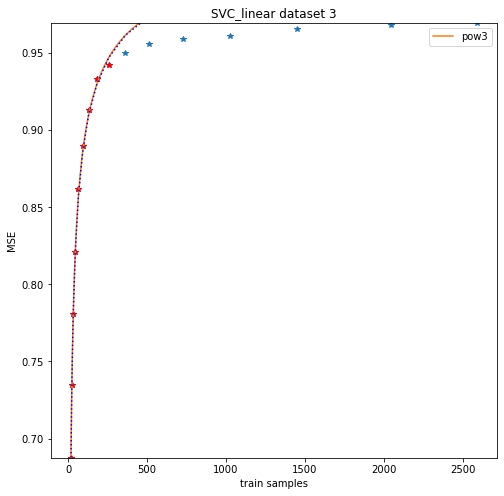

In [85]:
curve_model = 'pow3'
learner = 'SVC_linear'
openmlid = 3
n = 9
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected2 = df_selected.query('curve_model==@curve_model')

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

row = df_selected.iloc[0,:]
offset = np.argwhere(X == row.max_anchor_seen)[0][0]

X_trn = X[:offset+1]
Y_trn = Y[:offset+1]

beta = parse_beta(df_selected2.beta.values)
fun = get_fun_model_id(beta,curve_model)

prediction_precomputed = parse_prediction(df_selected2.prediction.values)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
plt.plot(X_trn,Y_trn,'*r')

X_plot = np.arange(np.min(X),np.max(X))
Y_hat = fun(X_plot)
plt.plot(X_plot,Y_hat,'-',label=curve_model)
plt.plot(X,prediction_precomputed,':b')
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


# Distribution of MSEs

In [86]:
df_total_clean

quartile  Unnamed: 0  openmlid                           learner  \
0              0           0         3                        SVC_linear   
1              0           1         3                        SVC_linear   
2              0           2         3                        SVC_linear   
3              1           3         3                        SVC_linear   
4              1           4         3                        SVC_linear   
...          ...         ...       ...                               ...   
301198         2      301198       910  sklearn.tree.ExtraTreeClassifier   
301199         3      301199       910  sklearn.tree.ExtraTreeClassifier   
301200         3      301200       910  sklearn.tree.ExtraTreeClassifier   
301201         4      301201       910  sklearn.tree.ExtraTreeClassifier   
301202         4      301202       910  sklearn.tree.ExtraTreeClassifier   

        max_anchor_seen                                         prediction  \
0                    45  [0.6866 0.7361 0.7793 0.8221 0.8645 0.9051 0.9...   
1                    64  [0.6864 0.7363 0.7793 0.8214 0.8626 0.9016 0.9...   
2                    91  [0.6851 0.7377 0.7808 0.8211 0.8587 0.8925 0.9...   
3                   128  [0.6842 0.7388 0.7823 0.822  0.858  0.8894 0.9...   
4                   181  [0.6837 0.7392 0.783  0.8224 0.8577 0.8881 0.9...   
...                 ...                                                ...   
301198              181  [0.5886 0.5941 0.601  0.6105 0.6234 0.6402 0.6...   
301199              256  [0.5884 0.594  0.601  0.6105 0.6235 0.6401 0.6...   
301200              362  [0.5872 0.5933 0.6009 0.6111 0.6246 0.6414 0.6...   
301201              512  [0.5889 0.5944 0.6013 0.6106 0.6232 0.6392 0.6...   
301202               45  [0.5864 0.5947 0.6023 0.6103 0.6186 0.627  0.6...   

                                                     beta  Unnamed: 0  \
0       (1.8259050363918465, 1.60011081278419, 0.12250...         0.0   
1       (1.5915489561835012, 1.3955173506046286, 0.156...         1.0   
2       (1.1986751382205407, 1.171780585157037, 0.2975...         2.0   
3       (1.1121255708956674, 1.2130204193755982, 0.375...         3.0   
4       (1.0833170977575124, 1.253142327625819, 0.4122...         4.0   
...                                                   ...         ...   
301198  (0.5753458616238681, 0.004154392649784833, 0.7...    301198.0   
301199  (0.5749522907733776, 0.004518543132001887, 0.7...    301199.0   
301200  (0.5721038164336356, 0.0060192684292096395, 0....    301200.0   
301201  (0.5754515084312327, 0.005024525275534144, 0.7...    301201.0   
301202  (9.519175864641886, 68.88682905700273, -0.0411...    301202.0   

         MSE_trn   MSE_tst  MSE_tst_last    L1_trn    L1_tst  L1_tst_last  \
0       0.000001  0.020309      0.060189  0.000001  0.020309     0.060189   
1       0.000001  0.016770      0.045341  0.000001  0.016770     0.045341   
2       0.000005  0.005540      0.013464  0.000005  0.005540     0.013464   
3       0.000008  0.002852      0.006278  0.000008  0.002852     0.006278   
4       0.000009  0.002108      0.004178  0.000009  0.002108     0.004178   
...          ...       ...           ...       ...       ...          ...   
301198  0.000052  0.000904      0.001640  0.000052  0.000904     0.001640   
301199  0.000067  0.000471      0.000729  0.000067  0.000471     0.000729   
301200  0.000082  0.000153      0.000216  0.000082  0.000153     0.000216   
301201  0.000075  0.000222      0.000213  0.000075  0.000222     0.000213   
301202  0.000078  0.000079      0.000079  0.000078  0.000079     0.000079   

        max anchor seen  percentage     n curve_model  
0                  45.0        0.02   4.0        pow3  
1                  64.0        0.02   5.0        pow3  
2                  91.0        0.04   6.0        pow3  
3                 128.0        0.05   7.0        pow3  
4                 181.0        0.07   8.0        pow3  
...                 

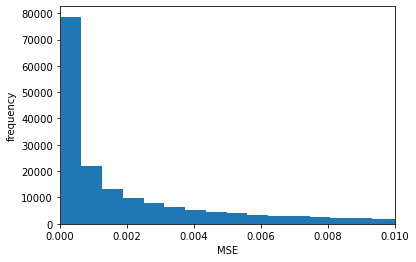

In [108]:
# MSE trn	MSE tst	MSE_tst_last	L1 trn	L1 tst	L1 tst last	max anchor seen

low, high = df_total_clean['MSE_tst_last'].quantile([0.1,0.9])
df_filtered = df_total_clean.query('{low}<MSE_tst_last<{high}'.format(low=low,high=high))
plt.hist(df_filtered['MSE_tst_last'],bins=1000)
plt.xlabel('MSE')
plt.ylabel('frequency')
plt.xlim([0,0.01])
plt.show()


# Learning curve of a learning curve

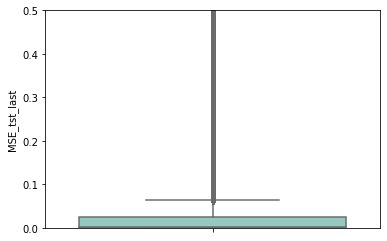

In [99]:
import seaborn as sns
plt.figure()
sns.boxplot(y="MSE_tst_last", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.5])
plt.show()

In [89]:
percentage = 0.25
percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)
bucket = np.argwhere(percentage < percentage_buckets)[0][0]
bucket

3

In [90]:
#df_total_clean = df_total_clean.query('openmlid == 11')

percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)

buckets = []

for i in range(0,len(df_total_clean)):
    row = df_total_clean.iloc[i,:]
    percentage = row.percentage
    bucket = np.argwhere(percentage < percentage_buckets)[0][0]
    buckets.append(bucket)

df_total_clean.insert(0,'quartile',buckets)


ValueError: cannot insert quartile, already exists

In [ ]:
df_total_clean['quartile'].hist()

In [54]:
type(row)

pandas.core.series.Series

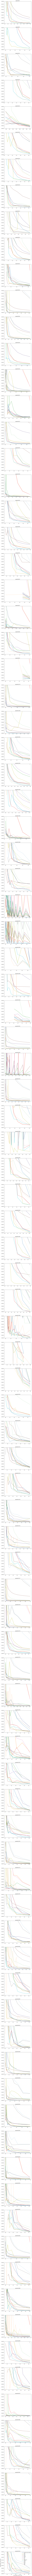

In [55]:
selected = df_total_clean
#selected = df_total_clean.query('openmlid == 11')

num_datasets = len(selected['openmlid'].unique())

fig, axs = plt.subplots(num_datasets,figsize = (8,8*num_datasets))

j = 0
for openmlid, df_dataset in selected.groupby("openmlid"):
    i = 0
    ls = '-'
    for curve_model, df_curve_model in df_dataset.groupby("curve_model"):

        Y = df_curve_model.groupby('percentage')['MSE_tst_last'].median()
        Y_sigma = df_curve_model.groupby('percentage')['MSE_tst_last'].std()
        X = df_curve_model.groupby('percentage')['MSE_tst_last'].median().index
        if i > 9:
            ls = ':'
        if num_datasets > 1:
            my_ax = axs[j]
        else:
            my_ax = axs
        my_ax.plot(X,Y,ls,label=curve_model)
        
        i += 1
    my_ax.set_ylim([0,0.002])
    my_ax.set_title('openmlid %d' % openmlid)
    j += 1
    
plt.xlabel('percentage of anchors used')
plt.ylabel('median MSE on last anchor')
plt.legend()
plt.show()


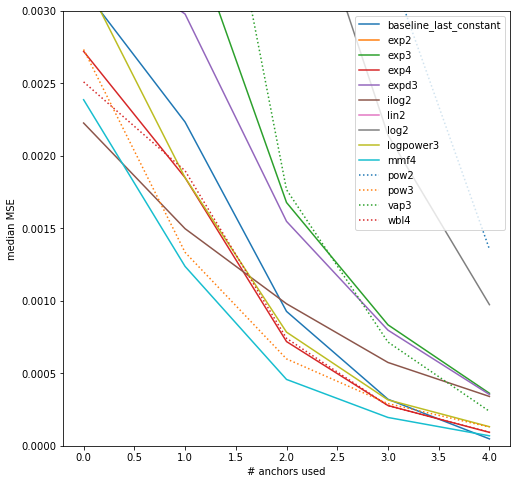

In [91]:
selected = df_total_clean

plt.figure(figsize=(8,8))

ls = '-'
i = 0
for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('quartile')['MSE_tst_last'].median()
    Y_sigma = df_curve_model.groupby('quartile')['MSE_tst_last'].std()
    X = df_curve_model.groupby('quartile')['MSE_tst_last'].median().index

    if i > 9:
        ls = ':'
    i += 1
    plt.plot(X,Y,ls,label=curve_model)
    
plt.xlabel('# anchors used')
plt.ylabel('median MSE')
plt.legend()
plt.ylim([0,0.003])
plt.show()


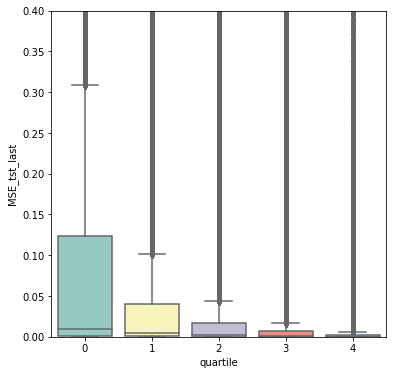

In [116]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.boxplot(x="quartile", y="MSE_tst_last", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.4])
plt.show()

In [118]:
percentage_buckets_str = ['curve_model']
for perc in percentage_buckets:
    percentage_buckets_str.append(str(perc))
percentage_buckets_str = percentage_buckets_str

In [ ]:
row

In [ ]:
rows

In [ ]:
percentage_buckets_str

In [119]:
rows = []
for curve_model, df_subgroup in df_total_clean.groupby(["curve_model"]):
    row = [curve_model]
    for quartile, df_subgroup2 in df_subgroup.groupby(['quartile']):
        row.append(df_subgroup2['MSE_tst_last'].median())
    rows.append(row)
    
my_res = pd.DataFrame(rows,columns=[percentage_buckets_str])



In [ ]:
my_res

In [121]:
my_res_ranks = my_res.copy()
for col in percentage_buckets_str:
    if col == 'curve_model':
        continue
    my_res_ranks[col] = my_res_ranks[col].rank(method='average')
my_res_ranks['0.05']

0.05
0    6.0
1   14.0
2    9.0
3    4.0
4    8.0
5    1.0
6   13.0
7   11.0
8    7.0
9    2.0
10  12.0
11   5.0
12  10.0
13   3.0

In [122]:
print('\\begin{table}[]')
print('\\ttfamily')
print('\\begin{tabular}{lllll}')
for (i,text) in enumerate(percentage_buckets_str):
    if text == 'curve_model':
        text = 'curve model'
    if i == 0:
        print('%12s' % text,' ',end='')
    else:
        print('%8s' % text,' ',end='')
    if i < 4:
        print('&',end='')
print('\\\\')
first = True
for i in range(0,len(my_res)):
    row = my_res.iloc[i,:]
    for (j,num) in enumerate(row.values):
        if j == 0:
            if num == 'baseline_last_constant':
                num = 'last1'
            print('%12s' % num,' ',end='')
        else:
            rank = my_res_ranks.iloc[i,j]
            if rank >= 1 and rank <= 3.5: # [1,2,3]:
                print('\\cellcolor{YellowGreen}{%8.5f} '%num,end='')
            elif rank > 3.5 and rank <= 7.5: # in [4, 5, 6, 7]:
                print('\\cellcolor{Goldenrod}{%8.5f} '%num,end='')
            elif rank > 7.5 and rank <= 10.5: #rank in [8, 9, 10]:
                print('\\cellcolor{White}{%8.5f} '%num,end='')
            elif rank > 10.5 and rank <= 14: # rank in [12,13,14]:
                print('\\cellcolor{Gray}{%8.5f} '%num,end='')
            else:
                print('\\cellcolor{Red}{%8.5f} '%num,end='')
                #print(' ')
                #print(rank)
                #print(' ')
        if j < 4:
            print('&',end='')
    print('\\\\')
print('\\end{tabular}')
print('\\end{table}')

\begin{table}[]
\ttfamily
\begin{tabular}{lllll}
 curve model  &    0.05  &     0.1  &     0.2  &     0.4       1.0  \\
       last1  &\cellcolor{Goldenrod}{ 0.00315} &\cellcolor{Goldenrod}{ 0.00223} &\cellcolor{Goldenrod}{ 0.00093} &\cellcolor{Goldenrod}{ 0.00032} \cellcolor{YellowGreen}{ 0.00005} \\
        exp2  &\cellcolor{Gray}{737208457.39336} &\cellcolor{Gray}{26.96218} &\cellcolor{Gray}{ 1.72467} &\cellcolor{Gray}{ 0.23256} \cellcolor{Gray}{ 0.02000} \\
        exp3  &\cellcolor{White}{ 0.00507} &\cellcolor{White}{ 0.00365} &\cellcolor{White}{ 0.00168} &\cellcolor{White}{ 0.00083} \cellcolor{White}{ 0.00036} \\
        exp4  &\cellcolor{Goldenrod}{ 0.00272} &\cellcolor{Goldenrod}{ 0.00185} &\cellcolor{YellowGreen}{ 0.00072} &\cellcolor{YellowGreen}{ 0.00028} \cellcolor{YellowGreen}{ 0.00009} \\
       expd3  &\cellcolor{White}{ 0.00347} &\cellcolor{White}{ 0.00298} &\cellcolor{White}{ 0.00155} &\cellcolor{White}{ 0.00080} \cellcolor{White}{ 0.00035} \\
       ilog2  &\cellcolor

In [123]:
a = df_total_clean.groupby('curve_model')['MSE_tst_last'].median()
a.sort_values()

curve_model
mmf4                      0.000463
exp4                      0.000641
pow3                      0.000644
wbl4                      0.000648
logpower3                 0.000789
baseline_last_constant    0.000808
ilog2                     0.001005
expd3                     0.001393
exp3                      0.001607
vap3                      0.002472
log2                      0.005279
pow2                      0.008287
lin2                      0.830964
exp2                      1.910344
Name: MSE_tst_last, dtype: float64

In [ ]:
df_total_clean['learner']

In [124]:
df_total_clean.groupby('learner')['MSE_tst_last'].median().sort_values()

learner
sklearn.naive_bayes.BernoulliNB                                0.000481
sklearn.naive_bayes.MultinomialNB                              0.001034
sklearn.linear_model.PassiveAggressiveClassifier               0.001165
sklearn.linear_model.LogisticRegression                        0.001505
sklearn.linear_model.RidgeClassifier                           0.001832
SVC_linear                                                     0.001901
sklearn.linear_model.Perceptron                                0.002013
sklearn.neighbors.KNeighborsClassifier                         0.002167
sklearn.ensemble.ExtraTreesClassifier                          0.002269
SVC_poly                                                       0.002276
sklearn.ensemble.RandomForestClassifier                        0.002468
sklearn.linear_model.SGDClassifier                             0.002546
sklearn.tree.ExtraTreeClassifier                               0.003008
sklearn.tree.DecisionTreeClassifier                     

In [125]:
df_total_clean.describe()

quartile     Unnamed: 0       openmlid  max_anchor_seen  \
count  300941.000000  300941.000000  300941.000000    300941.000000   
mean        1.688125  150621.513396     479.126450      4340.345058   
std         1.506212   86975.009221     326.871231     26338.706457   
min         0.000000       0.000000       3.000000        45.000000   
25%         0.000000   75251.000000     180.000000       128.000000   
50%         2.000000  150660.000000     399.000000       362.000000   
75%         3.000000  225951.000000     807.000000      1024.000000   
max         4.000000  301202.000000     910.000000    524288.000000   

          Unnamed: 0       MSE_trn        MSE_tst   MSE_tst_last  \
count  300941.000000  3.009410e+05   3.009410e+05   3.009410e+05   
mean   150621.513396  2.183232e-03  3.582782e+298  7.059158e+299   
std     86975.009221  1.860452e-02            inf            inf   
min         0.000000  2.311116e-33   0.000000e+00   0.000000e+00   
25%     75251.000000  1.884452e-05   1.761525e-04   2.003923e-04   
50%    150660.000000  7.439272e-05   1.360323e-03   2.273001e-03   
75%    225951.000000  3.732162e-04   1.223753e-02   2.583863e-02   
max    301202.000000  7.623948e-01  4.578164e+303  8.240695e+304   

             L1_trn         L1_tst    L1_tst_last  max anchor seen  \
count  3.009410e+05   3.009410e+05   3.009410e+05    300941.000000   
mean   2.183232e-03  3.582782e+298  7.059158e+299      4411.454162   
std    1.860452e-02            inf            inf     26800.220741   
min    2.311116e-33   0.000000e+00   0.000000e+00        45.000000   
25%    1.884452e-05   1.761525e-04   2.003923e-04       128.000000   
50%    7.439272e-05   1.360323e-03   2.273001e-03       362.000000   
75%    3.732162e-04   1.223753e-02   2.583863e-02      1024.000000   
max    7.623948e-01  4.578164e+303  8.240695e+304    524288.000000   

          percentage              n  
count  300941.000000  300941.000000  
mean        0.189146      10.548274  
std         0.216448       5.080746  
min         0.000000       4.000000  
25%         0.030000       7.000000  
50%         0.100000      10.000000  
75%         0.300000      13.000000  
max         0.990000      31.000000

# Look at parameter values

In [134]:
beta

'(0.0008299352803331103, 0.5744844011737642)'

In [ ]:

beta_str = beta[0]
beta_str = beta_str[1:-1]
beta_parts = beta_str.split(' ')
myfloat = []
for part in beta_parts:
    part = part.replace(',','')
    part = part.replace('\n','')
    myfloat.append(float(part))
myfloat = tuple(myfloat)
return myfloat

In [126]:
num_curve_models = df_total_clean['curve_model'].unique()
num_curve_models

array(['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2',
       'baseline_last_constant', 'vap3', 'mmf4', 'wbl4', 'exp4', 'ilog2',
       'expd3', 'logpower3'], dtype=object)

In [131]:
row.beta

'(0.004610734323341358, 0.6226067086250324)'

In [139]:
beta_list

[(0.004610734323341358, 0.6226067086250324),
 (0.0035834446494649196, 0.6474396535302993),
 (0.0026399615206915087, 0.6742458112795706),
 (0.0019460673890021917, 0.6983153867508473),
 (0.0014137439749121277, 0.7203915741558317),
 (0.0009897228492883007, 0.7416646838245692),
 (0.0006934480288092594, 0.7601034014276343),
 (0.0004834733765123269, 0.7761683888805495),
 (0.0003341480588358486, 0.7901370398107429),
 (0.0002300453010721804, 0.8021065338240665),
 (0.0001600060696015253, 0.8120599056468646),
 (0.00011103292062847313, 0.820647549348581),
 (0.004865329505481254, 0.6103329712329165),
 (0.00384455826719495, 0.6348455277949375),
 (0.002839040625989108, 0.6629337240283784),
 (0.002080653541960756, 0.6893480714324373),
 (0.0014763132445218422, 0.714739916501589),
 (0.001033556009908172, 0.7373388421472177),
 (0.0007229474250035798, 0.7565982599747569),
 (0.000506786988143799, 0.7728244366684999),
 (0.00035577513244528566, 0.7865671983151152),
 (0.0002499017970561444, 0.798332245711455

In [165]:
df_selected

quartile  Unnamed: 0  openmlid                           learner  \
60             0          60         3                        SVC_linear   
61             0          61         3                        SVC_linear   
62             0          62         3                        SVC_linear   
63             1          63         3                        SVC_linear   
64             1          64         3                        SVC_linear   
...          ...         ...       ...                               ...   
301134         2      301134       910  sklearn.tree.ExtraTreeClassifier   
301135         3      301135       910  sklearn.tree.ExtraTreeClassifier   
301136         3      301136       910  sklearn.tree.ExtraTreeClassifier   
301137         4      301137       910  sklearn.tree.ExtraTreeClassifier   
301138         4      301138       910  sklearn.tree.ExtraTreeClassifier   

        max_anchor_seen                                         prediction  \
60                   45  [ 0.6964  0.7287  0.7702  0.8301  0.9177  1.04...   
61                   64  [0.7048 0.7299 0.7621 0.8087 0.8768 0.9735 1.1...   
62                   91  [0.7165 0.735  0.7587 0.793  0.8432 0.9145 1.0...   
63                  128  [0.7295 0.7431 0.7606 0.7859 0.8229 0.8754 0.9...   
64                  181  [0.743  0.7529 0.7656 0.784  0.8109 0.849  0.9...   
...                 ...                                                ...   
301134              181  [0.5886 0.5941 0.601  0.6105 0.6234 0.6402 0.6...   
301135              256  [0.5884 0.594  0.601  0.6105 0.6235 0.6401 0.6...   
301136              362  [0.5872 0.5933 0.6009 0.6111 0.6246 0.6414 0.6...   
301137              512  [0.5889 0.5944 0.6013 0.6106 0.6232 0.6392 0.6...   
301138               45  [0.5878 0.5936 0.601  0.6118 0.6276 0.65   0.6...   

                                                     beta  Unnamed: 0  \
60             (0.004610734323341358, 0.6226067086250324)        60.0   
61            (0.0035834446494649196, 0.6474396535302993)        61.0   
62            (0.0026399615206915087, 0.6742458112795706)        62.0   
63            (0.0019460673890021917, 0.6983153867508473)        63.0   
64            (0.0014137439749121277, 0.7203915741558317)        64.0   
...                                                   ...         ...   
301134  (-0.20595102682811126, 0.004154701145513254, 0...    301134.0   
301135  (-0.19336050344444702, 0.004518589009982513, 0...    301135.0   
301136  (-0.16424138382547085, 0.0060191498592650884, ...    301136.0   
301137  (-0.17377400158523104, 0.005024522462743193, 0...    301137.0   
301138        (0.0008299352803331103, 0.5744844011737642)    301138.0   

         MSE_trn    MSE_tst  MSE_tst_last    L1_trn     L1_tst  L1_tst_last  \
60      0.000076  24.363109    134.226906  0.000076  24.363109   134.226906   
61      0.000210  15.769601     80.135325  0.000210  15.769601    80.135325   
62      0.000513   9.165610     42.731501  0.000513   9.165610    42.731501   
63      0.000910   5.350897     22.706498  0.000910   5.350897    22.706498   
64      0.001409   3.036439     11.625601  0.001409   3.036439    11.625601   
...          ...        ...           ...       ...        ...          ...   
301134  0.000015   0.034225      0.125673  0.000015   0.034225     0.125673   
301135  0.000021   0.027006      0.082371  0.000021   0.027006     0.082371   
301136  0.000047   0.020923      0.050088  0.000047   0.020923     0.050088   
301137  0.000172   0.009544      0.017162  0.000172   0.009544     0.017162   
301138  0.000254   0.008428      0.008428  0.000254   0.008428     0.008428   

        max anchor seen  percentage     n curve_model  
60                 45.0        0.02   4.0        lin2  
61                 64.0        0.02   5.0        lin2  
62                 91.0        0.04   6.0        lin2  
63                128.0        0.05   7.0        lin2  
64                181.0        0.07   8.0        lin

In [162]:
plt.figure()
j = 0
df_selected = df_total_clean.query('curve_model == "lin2"')
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = parse_beta([row.beta])
        beta2 = list(beta)
        beta_list.append(beta2)

#    a = np.array(beta_list)
#    plt.boxplot(a)
#    plt.ylim([-0.25,0.25])


<Figure size 432x288 with 0 Axes>

In [164]:
for [i, beta] in enumerate(beta_list):
    if not len(beta) == 2:
        print(i,beta)

1376 [-0.28168703665606665, 0.019347212430177247, 0.6115132485538685]
1386 [-0.08234485994902499, 0.0032978478016822653, 0.177580381539819]
1396 [-0.31089299558875, 0.04529033978001517, 0.4541710023997009]
1406 [-0.2849247612142505, 0.026271301902958233, 0.6553640277887053]
1416 [-0.42757764913530494, 0.05556564711932978, 0.44489080678966975]
1426 [74.2220920533884, -1.967817376855797e-06, -74.1250497977098]
1436 [-0.34902613692776996, 0.035443684816968093, 0.6520557319649507]
1446 [-0.30808317897005555, 0.03564512097068605, 0.6364686942856668]
1456 [-0.4394983835913724, 0.024870225723684306, 0.8662420487434129]
1466 [-0.23516746016817125, 0.005832485834514539, 0.943444218496232]
1476 [-0.2350652118646943, 0.005423161201229389, 0.9373866365929576]
1486 [-0.187118814374586, 0.019238608659357254, 0.8319570033756842]
1496 [-0.1798291972612983, 0.010611718562929412, 0.8485214755286351]
1506 [-0.15606413390980092, 0.012358598665936563, 0.8312972243702282]
1516 [-0.19293535192082492, 0.00550

In [160]:
beta_list = []
i = 0
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
i = 1
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
i = 2
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
beta_list

[[0.004610734323341358, 0.6226067086250324],
 [0.0035834446494649196, 0.6474396535302993],
 [0.0026399615206915087, 0.6742458112795706]]

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

fig, axs = plt.subplots(len(num_curve_models),figsize=(15,15))
j = 0
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = parse_beta([row.beta])
        beta_list.append(beta)

    a = np.array(beta_list)
    axs[j].boxplot(a)
    axs[j].set_ylim([-2,2])
    axs[j].set_title(curve_model)
    j = j+1

In [ ]:
np.array(beta_list).shape

In [ ]:
total_list = np.empty((1,1))
total_list.shape

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

first = True
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)
    beta_list = np.array(beta_list)
    if first:
        total_list = np.reshape(beta_list,(-1,1))
        first = False
    else:
        total_list = np.hstack((total_list,beta_list))
    

In [ ]:
pd.DataFrame(total_list).describe()

In [ ]:
total_list.shape

# Visualize fits

In [ ]:
df_total_clean

In [ ]:
df

In [ ]:
learners = df['learner'].unique()
learners

In [ ]:

learner = learners[18]
openmlid = 11
n = 9
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
for i in range(0,len(df_selected)):
    row = df_selected.iloc[i,:]
    Y_hat = row.prediction
    plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
learner = 'sklearn.linear_model.Perceptron'

In [ ]:
#    def exp3(beta):
#        a, b, c = tuple(beta.astype(float))
#        pl = lambda x: a * np.exp(-b*x) + c

In [ ]:
def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([0.0001,0.2,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d

In [ ]:
[beta,func] = get_exp2_good_init(X,Y)

In [ ]:
Y_hat

In [ ]:
learner = learners[0]
openmlid = 11

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

beta, pow4 = get_pow4(X,Y)

Y_hat = pow4(X)

plt.figure()
plt.plot(X,Y,'*')
plt.plot(X, Y_hat, '-o')


In [ ]:
beta

In [ ]:
beta

# Learner influence

In [ ]:
df_total_clean.boxplot(column='MSE_tst_last',by='learner',rot=90)
plt.ylim([0,0.1])

# Curve model influence

In [ ]:
df_total_clean.boxplot(column='MSE_tst_last',by='curve_model',rot=90)
plt.ylim([0,0.1])

# Compute Jacobians

In [ ]:
from sympy.utilities.lambdify import lambdify

x = sym.Symbol('x')
y = sym.Symbol('y')
a = sym.Symbol('a')
b = sym.Symbol('b')
c = sym.Symbol('c')
d = sym.Symbol('d')

def get_fun_sym(model_id):
    if model_id == 'pow2':
        fun = sym.Matrix([-a * x **(-b)])
        J = np.array([-X**(-b), a*X**(-b)*np.log(X)])
    if model_id == 'pow3':
        fun = sym.Matrix([a - b * x **(-c)])
        J = np.array([np.ones_like(X), -X**(-c), b*X**(-c)*np.log(X)])
    if model_id == 'log2':
        fun = sym.Matrix([-a * sym.log(x) + b])
        J = np.array([-np.log(X), np.ones_like(X)])
    if model_id == 'exp3':
        fun = sym.Matrix([a * sym.exp(-b*x) + c])
        J = np.array([exp(-b*X), -a*X*np.exp(-b*X), np.ones_like(X)])
    if model_id == 'exp2':
        fun = sym.Matrix([a * sym.exp(-b*x)])
        J = np.array([exp(-b*X), -a*X*exp(-b*X)])
    if model_id == 'lin2':
        fun = sym.Matrix([a * x + b])
        J = np.array([X, np.ones_like(X)])
    if model_id == 'vap3':
        fun = sym.Matrix([sym.exp(a + b/x + c * sym.log(x))])
        J = np.array([np.exp(a + b/X + c*np.log(X)), np.exp(a + b/X + c*log(X))/X, np.exp(a + b/X + c*np.log(X))*np.log(X)])
    if model_id == 'mmf4':
        fun = sym.Matrix([(a * b + c * x ** d)/(b + x ** d)])
        J = np.array([b/(b + X**d), a/(b + X**d) - (a*b + c*X**d)/(b + X**d)**2, X**d/(b + X**d), c*X**d*np.log(X)/(b + X**d) - X**d*(a*b + c*X**d)*np.log(X)/(b + X**d)**2])
    if model_id == 'wbl4':
        fun = sym.Matrix([(c - b * sym.exp(-a*(x**d)))])
        J = np.array([b*X**d*np.exp(-a*X**d), -np.exp(-a*X**d), np.ones_like(X), a*b*X**d*np.exp(-a*X**d)*np.log(X)])
    if model_id == 'exp4':
        fun = sym.Matrix([c - sym.exp(-a*(x**d) + b)])
        J = np.array([X**d*np.exp(-a*X**d + b), -np.exp(-a*X**d + b), np.ones_like(X), a*X**d*np.exp(-a*X**d + b)*np.log(X)])
    if model_id == 'expp3':
        fun = sym.Matrix([c - sym.exp((x-b)**a)])
        J = np.array([-(-b + X)**a*np.exp((-b + X)**a)*np.log(-b + X), a*(-b + X)**a*np.exp((-b + X)**a)/(-b + X), np.ones_like(X)])
    if model_id == 'pow4':
        fun = sym.Matrix([a - b*(x + d)**(-c)]) # has to closely match pow3
        J = np.array([np.ones_like(X), -(d + X)**(-c), b*(d + X)**(-c)*np.log(d + X), b*c*(d + X)**(-c)/(d + X)])
    if model_id == 'ilog2':
        fun = sym.Matrix([b - (a/sym.log(x))])
        J = np.array([-1/log(X), np.ones_like(X)])
    if model_id == 'expd3':
        fun = sym.Matrix([c - (c - a)*sym.exp(-b*x)])
        J = np.array([np.exp(-b*X), -X*(a - c)*np.exp(-b*X), np.ones_like(X) - np.exp(-b*X)])
    if model_id == 'logpower3':
        fun = sym.Matrix([a / (1 + (x / sym.exp(b))**c)])
        J1 = ((X*np.exp(-b))**c + np.ones_like(X))**(-1.0)
        J2 = a*c*(X*np.exp(-b))**c/((X*np.exp(-b))**c + np.ones_like(X))**2
        J3 = -a*(X*np.exp(-b))**c*np.log(X*np.exp(-b))/((X*np.exp(-b))**c + np.ones_like(X))**2
        J = np.array([J1, J2, J3])
    return fun

model_id = 'logpower3'
fun = get_fun_sym(model_id)
num_par = get_num_par(model_id)
if num_par == 2:
    beta = sym.Matrix([a,b])
if num_par == 3:
    beta = sym.Matrix([a,b,c])
if num_par == 4:
    beta = sym.Matrix([a,b,c,d])
    
J = fun.jacobian(beta)
if num_par == 2:
    fastJ = lambdify(['a','b','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],x)
if num_par == 3:
    fastJ = lambdify(['a','b','c','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],x)
if num_par == 4:
    fastJ = lambdify(['a','b','c','d','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],beta[3],x)

inspect.getsource(fastJ)

In [ ]:
from sympy.utilities.lambdify import lambdify
inspect.getsource(fastJ)